<center><h1>Предобработка текста и определение языка (Вариант А)</h1></center>




Данное исследование посвящено проблеме автоматического определения языка в близкородственных языках (т.е. языках с одинаковым алфавитом). Задача состоит в том, чтобы определить, к какому из известного набор n языков относится рассматриваемый документ.

Для решения этой задачи мы разбиваем слова каждого языка на символьные триграмы -- все возможные комбинации подряд идущих троек символов -- таким образом, для каждого языка набор таких триграмов будет уникален, и большое число совпадений триграмов в документе с одним из наборов и будет говорить о языке документа.

Теперь вопрос возникает в том, откуда взять эти наборы для каждого языка, и каким образом подсчитывать совпадения. Мы считатем, что данная задача может быть решена при помощи алгоритмов машинного обучения и Википедии. Иными словами, для получения триграмов будет выкачано по *n* случайных статей Википедии для каждого из k языков. Далее, все n\*k статей будет объединены в набор, каждая статья в котором будет векторизована по документному индексу n-грамов: каждой статье будет ассиироцан вектор, компонентами которого будут являться ВСЕ возможные n-грамы, встречающиеся в наборе (т.е. на всех языках), а значениями будут являтья число вхождений данного n-грама в документ. Таким образом, предполагается, что вектора документов на одном и том же языки будут похожи, потому что в них будут относительно часто встречаться некоторые часто используемые n-грамы на одном языке, а на других языках встречаться не будут.

При этом мы также знаем язык каждого документа из рассматриваемой выборки. Значит, данную задачу мы можем рассматривать как задачу классификации, и использовать в качестве признакового пространство полученные документные вектора, а в качестве меток классов -- языки документов. Теоретически, для каждого нового документа мы сможем таким образом предскзаывать язык, на котором он написан -- т.е. метку класса в терминах классификации. Для того, чтобы проверить, насколько хорошо работает предлагаемый нами алгоритм, мы будем использовать кросс-валидацию на обучающей выборке документов, используя её часть как тестовый сет.

In [1]:
import wikipedia
from collections import defaultdict
from time import sleep
from pickle import dump, load
from itertools import chain
from pandas import DataFrame
import re
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier

from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

Мы решили использовать следующий набор языков: английский, французский, испанский, чешский. Таким образом, задача будет заключаться в том, чтобы определить, на каком языке из этого набора написан рассматриваемый документ. 

In [2]:
languages = ['en', 'fr', 'cz', 'es']
pages, labels = defaultdict(lambda: []), defaultdict(lambda: [])

Очень важный этап при работе с текстом это предобработка. Предобработка заключается в удалении элементов текста, которые могут добавить шум -- лишнюю информацию, затрудняющую и ухудшаю работку классификатора. В нашем случае шумом будут являться все небуквенные символы (non-alphanumeric), гиперссылки, и тому подобное. Для предобработки были выбраны регулярные выражения, ощичающие текст до формата: "слова без чисел, знаков препинания, знаков табуляции, разделенные пробелами".

In [3]:
def normalize(text):
    reg_exps = (re.compile('[^\w ]+'), re.compile('[\d]+'), re.compile('[ ]+'))
    for reg in reg_exps:
        text = reg.sub(' ', text)
    return text.strip().lower()

Сравните:

In [4]:
wikipedia.set_lang(languages[0])
article = wikipedia.page(wikipedia.random()).content
print(article[:500])

The Price–Harney Truce was a document signed on May 21, 1861, between United States Army General William S. Harney (Commander of the U.S. Army's Western Department) and Missouri State Guard commander Sterling Price at the beginning of the American Civil War.
The truce sought to forestall the outbreak of violence in the state of Missouri following the Camp Jackson Affair, in which Union army troops under the command of Captain Nathaniel Lyon had captured Missouri State Militia mustered on the out


In [5]:
normalize(article[:500])

'the price harney truce was a document signed on may between united states army general william s harney commander of the u s army s western department and missouri state guard commander sterling price at the beginning of the american civil war the truce sought to forestall the outbreak of violence in the state of missouri following the camp jackson affair in which union army troops under the command of captain nathaniel lyon had captured missouri state militia mustered on the out'

После того, как мы выбрали методы предобработки, перейдём непосредственно к краулингу статей из Википедии. Мы решили взять 1200 статей, для каждого из языков будет по 300 :-)

In [6]:
AMOUNT_OF_PAGES = 300

In [ ]:
for language_id, language in enumerate(languages):
    wikipedia.set_lang(language)
    for page_title in wikipedia.random(AMOUNT_OF_PAGES):
        title = page_title
        if 'disambig' in page_title: 
            title = page_title.split(' ')[0] 
        while(True):
            try:
                normalized_text = normalize(wikipedia.page(str(wikipedia.search(title)[0])).content)
                pages[language].append(normalized_text)
                labels[language].append(language_id)
                break
            except wikipedia.DisambiguationError:
                title = wikipedia.random(1)
            except wikipedia.PageError:
                pass

 Для того, чтобы работать со статьями было удобнее, засунем их в ```DataFrame``` и сериализуем:

In [5]:
FILENAME = 'wikipedia_languages.csv'

In [3]:
data = DataFrame(list(zip(list(chain.from_iterable(pages[language] for language in languages)), 
                          list(chain.from_iterable(labels[language] for language in languages)))),
                          columns=['text', 'language'])

# data.to_csv(FILENAME, encoding='utf-8') # uncomment if you want to serialize

Теперь скрауленные данные хранятся на диске, и для того, чтобы обращаться к ним, не нужно скаичивать все статьи заново:

In [6]:
data = DataFrame.from_csv(FILENAME, encoding='utf-8').dropna().reset_index(drop=True)

Эти данные мы можем преобразовать в признаковые вектора с помощью различных векторизаторов; целевым вектором соответственно будет выступать с метками языков:

In [7]:
countvect_char_wb = [('2-gram', TfidfVectorizer(ngram_range=(1, 2), analyzer='char', binary=False)), 
                    ('3-gram',TfidfVectorizer(ngram_range=(1, 3), analyzer='char', binary=False)),
                    ('4-gram',TfidfVectorizer(ngram_range=(1, 4), analyzer='char', binary=False)),
                    ('5-gram',TfidfVectorizer(ngram_range=(1, 5), analyzer='char', binary=False))]

In [12]:
estimators = [(svm.LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0), 'Linear SVC', 'o', 'brown'), 
              (svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear', max_iter=-1, probability=False, random_state=None, shrinking=True,tol=0.001, verbose=False), 'SVC', 'o', 'red'),
              (LogisticRegression(tol=1e-8, penalty='l2', C=0.1), 'Logistic Regression', 'v', 'green'),
             (RandomForestClassifier(n_estimators=50), 'Random Forest', 'v', 'blue')]

In [9]:
Y = data.language.values

Таким образом, с помощью кросс-валидации мы можем оценить качество классификации по $F_1$-мере, не используя отдельную тестовую выборку. Мы можем проверить качество решения задачи на разных классификаторах и проверить его зависимость от объёма тестовой выборки:

In [10]:
CROSS_VAL_FOLDS = 3
TEST_CHUNK = 0.4
CROSS_VAL_CHUNK = 0.6

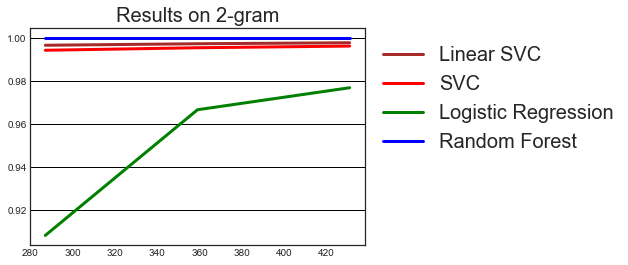

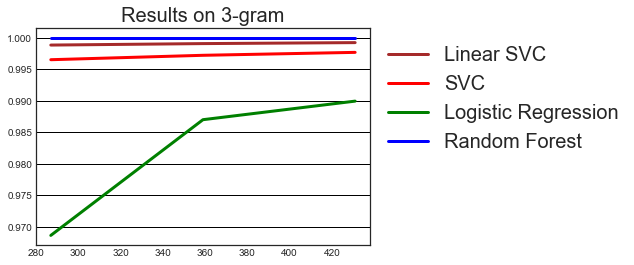

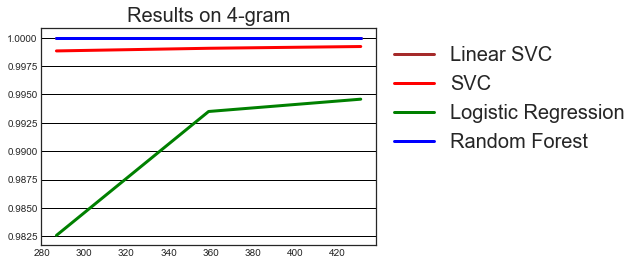

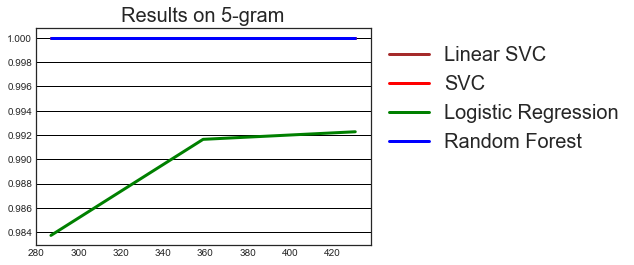

In [13]:
for countvect in countvect_char_wb:
    X = countvect[1].fit_transform(data.text.values)
    for estimator, name, markerstyle, colorstyle in estimators:
        cv = ShuffleSplit(n_splits=CROSS_VAL_FOLDS, test_size=TEST_CHUNK, random_state=0)
        train_sizes=np.linspace(TEST_CHUNK, CROSS_VAL_CHUNK, CROSS_VAL_FOLDS)
        train_sizes, train_scores, test_scores = learning_curve(estimator, X, Y, cv=cv, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        plt.plot(train_sizes, train_scores_mean, markersize=15, label=name, linewidth=3, color=colorstyle)
    plt.title('Results on {}'.format(countvect[0]), fontsize=20)
    plt.grid(True, axis='y', linewidth=1, color='black')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), prop={'size':20})
    plt.show()

Построив confusion matrix, мы можем определить, какие языки оказались очень похожи друг на друга, а какие нет (иными словами, какие языки проще различить по n-грамам).

In [16]:
LOWER_BOUND = 1
UPPER_BOUND = 25
TEST_SIZE = 0.3

In [17]:
train, test = train_test_split(data, test_size=TEST_SIZE)

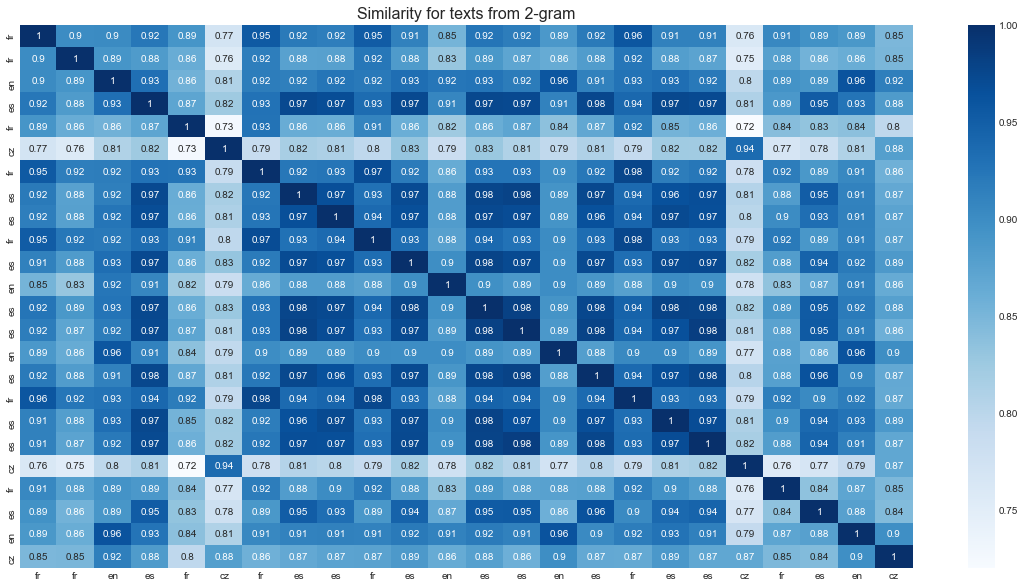

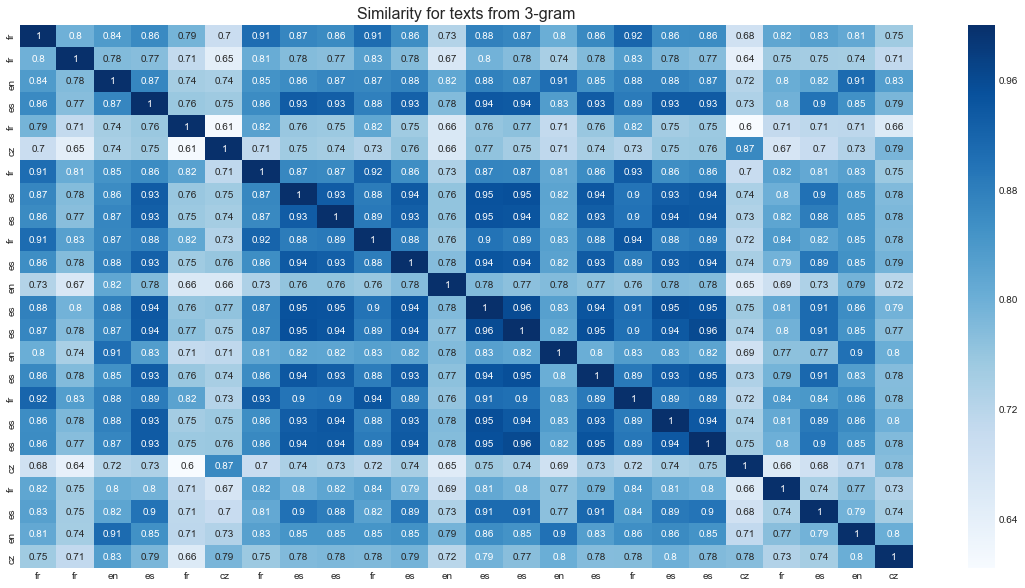

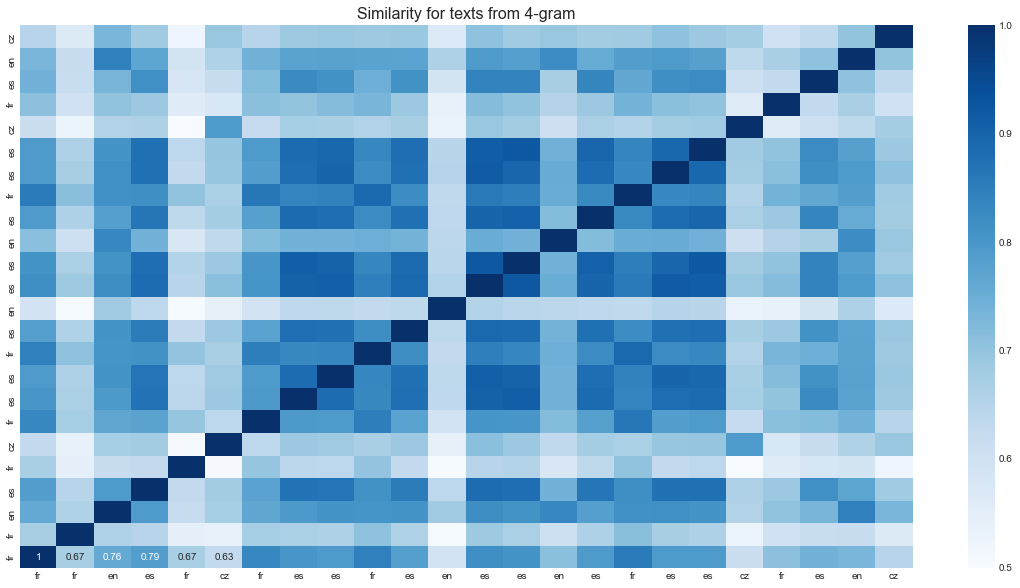

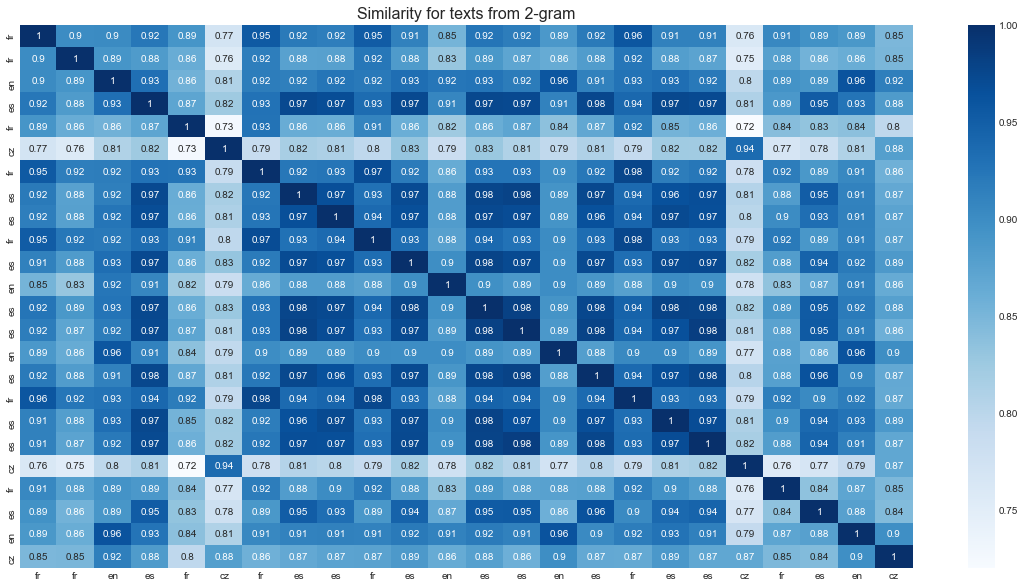

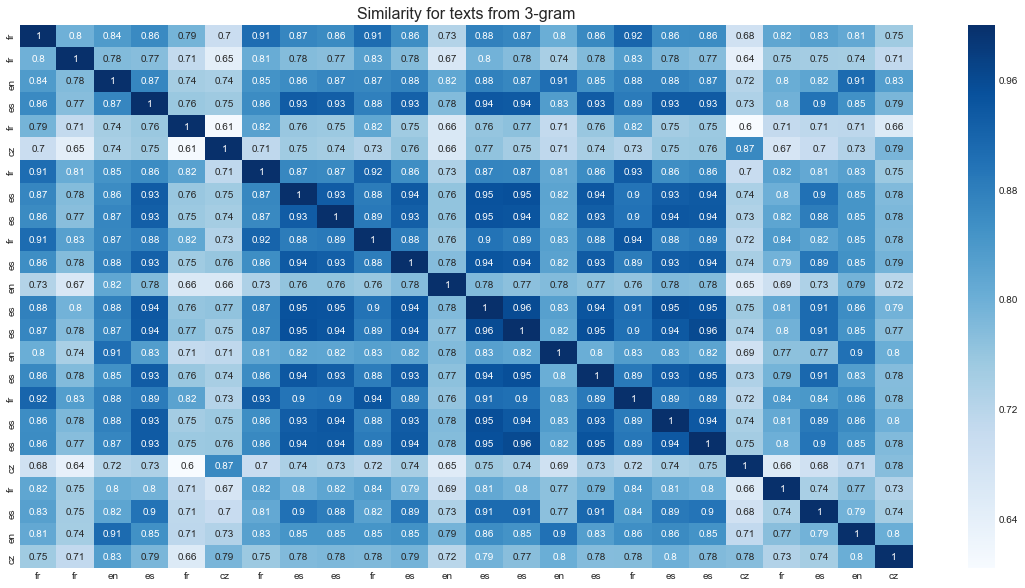

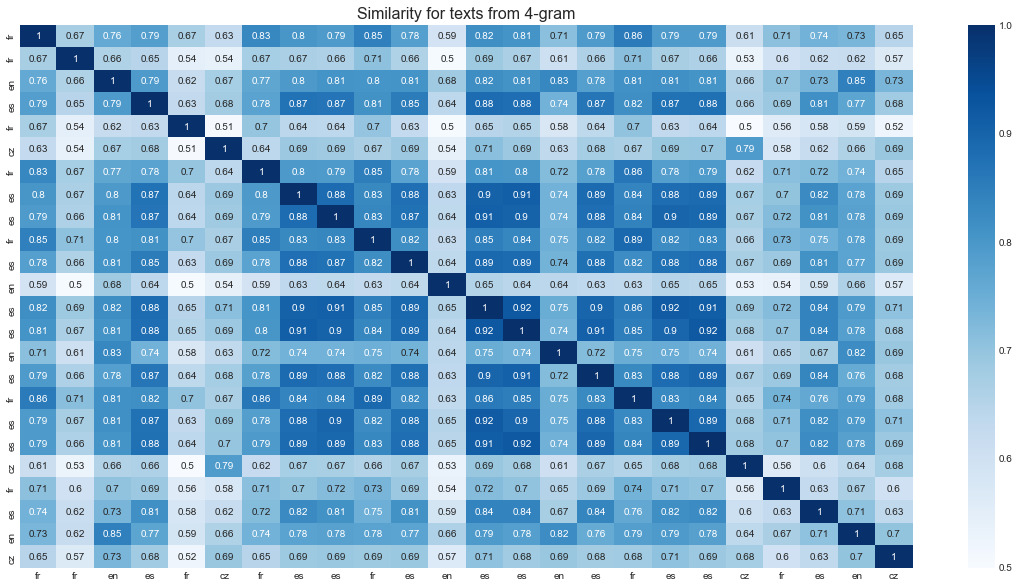

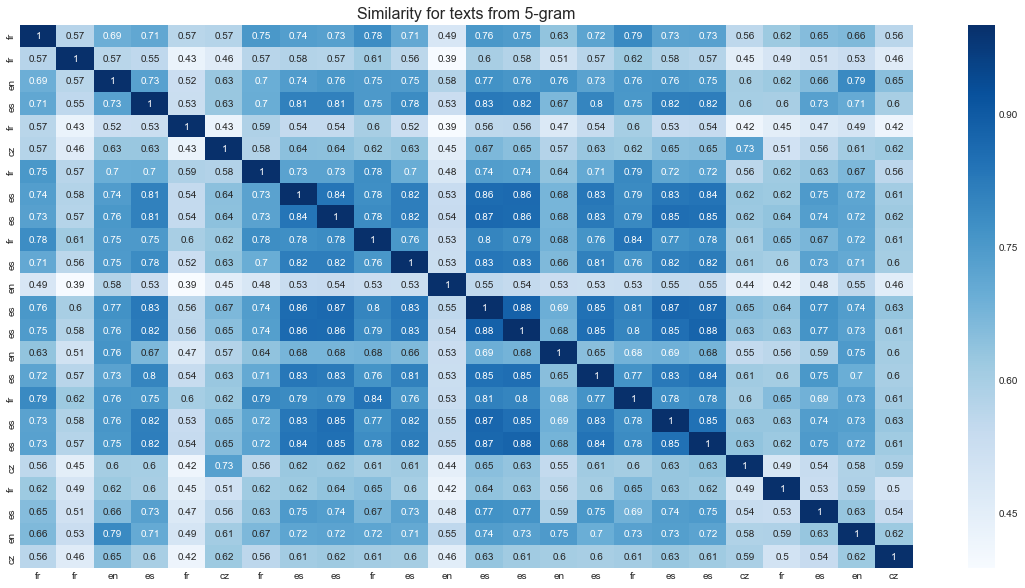

In [24]:
for countvect in countvect_char_wb:
    sp_matrix = countvect[1].fit_transform(train.text.values[LOWER_BOUND:UPPER_BOUND], train.language.values[LOWER_BOUND:UPPER_BOUND])
    similarities = cosine_similarity(sp_matrix)
    lan = [languages[i] for i in train.language.values[LOWER_BOUND:UPPER_BOUND]]
    df_cm = DataFrame(similarities, columns=lan, index=lan)
    plt.figure(figsize=(20,10))
    plt.title('Similarity for texts from '+countvect[0], fontsize=16)
    sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.show()

In [25]:
for countvect in countvect_char_wb:
    for estimator, name, markerstyle, colorstyle in estimators:
        char_model = Pipeline([('vect', countvect[1]), ('logr', estimator)])
        char_model.fit(train.text.values, train.language.values)
        target_names = languages
        report = classification_report(test.language.values, char_model.predict(test.text.values), target_names=target_names)
        print('Vectorizer: {}, Estimator: {}\n{}\nMicro F1-score={:0.2f}, Precision={:0.2f}, Recall={:0.2f}'.format(countvect[0], name, report, 
                                                                        f1_score(char_model.predict(test.text.values), test.language.values, average='micro'),
                                                                        precision_score(char_model.predict(test.text.values), test.language.values, average='micro'),
                                                                        precision_score(char_model.predict(test.text.values), test.language.values, average='micro')))
        print('=====================================================')

Vectorizer: 2-gram, Estimator: Linear SVC
             precision    recall  f1-score   support

         en       1.00      0.99      0.99        88
         fr       0.99      1.00      0.99        85
         cz       1.00      0.99      0.99        92
         es       0.99      1.00      0.99        95

avg / total       0.99      0.99      0.99       360

Micro F1-score=0.99, Precision=0.99, Recall=0.99
Vectorizer: 2-gram, Estimator: SVC
             precision    recall  f1-score   support

         en       1.00      0.99      0.99        88
         fr       0.99      0.99      0.99        85
         cz       1.00      0.99      0.99        92
         es       0.98      1.00      0.99        95

avg / total       0.99      0.99      0.99       360

Micro F1-score=0.99, Precision=0.99, Recall=0.99
Vectorizer: 2-gram, Estimator: Logistic Regression
             precision    recall  f1-score   support

         en       0.98      0.99      0.98        88
         fr       0.99   

In [26]:
from sklearn.feature_selection import RFE

X = countvect_char_wb[1][1].fit_transform(data.text.values)

svc = svm.LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0)       
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, Y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Ranking of pixels with RFE')
plt.show()

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


X = countvect_char_wb[1][1].fit_transform(data.text.values)
svc = LogisticRegression(C=0.1)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, Y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Таким образом, в проведенном исследовании мы предложили алгоритм для автоматического определения языка по n-грамам. Мы сравнили несколько разных способов векторизации и несколько разных классификаторов; нам удалось достигнуть хорошего качество, а также понять, какие языки являются более похожими друг на друга, а какие менее.

В продолжение данной работы мы планируем попробовать применить глубокие нейронные сети для классификации (например, LSTM), а также исследовать, могут ли другие лингвистические особенности языка предсказывать его -- например, падежная стратегия кодирования или порядок частей речи в предложении.